In [1]:
from alpha_vantage.timeseries import TimeSeries

# Get stock ticker input from user
ticker = input('Type the Ticker Label You Would Like To View: ')
api_key = 'GS2BJ46ZHTBI9E20'
# Pull and update fields from Alpha Vantage
try:
  ts = TimeSeries(key=api_key, output_format='pandas', indexing_type='integer')
  data, meta_data = ts.get_daily_adjusted(symbol=ticker, outputsize='full')
  data = data.drop(columns=['7. dividend amount','8. split coefficient'])
  df = data.rename(columns={'index':'date','1. open':'open', '2. high':'high', '3. low':'low',
  '4. close':'close','5. adjusted close':'adj close','6. volume':'volume'})
except:
  print(f"Error trying to import {ticker}")

In [2]:
# Arrange dataframe in sequential index/date order
df = df[::-1]
df.reset_index(drop=True, inplace=True)
df.head()
df.insert(0,"index", df.index)
data_set = df
data_set.head()

,index,date,open,high,low,close,adj close,volume
0,0,2010-06-29,19.00,25.0000,17.54,23.89,4.778,18766300.0
1,1,2010-06-30,25.79,30.4192,23.30,23.83,4.766,17187100.0
2,2,2010-07-01,25.00,25.9200,20.27,21.96,4.392,8218800.0
3,3,2010-07-02,23.00,23.1000,18.71,19.20,3.840,5139800.0
4,4,2010-07-06,20.00,20.0000,15.83,16.11,3.222,6866900.0


In [3]:
from sklearn.preprocessing import MinMaxScaler
# Pull close data from dataframe and reshape
close_data_set = data_set["close"].values.reshape(-1,1)
dataLength = len(close_data_set)
# Scale to normalize dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_set = scaler.fit_transform(close_data_set)

In [4]:
import math as m
# split into train and test sets sequentially for LSTM model
trainSize = m.ceil(int(dataLength * 0.8))
testSize = int(dataLength) - trainSize
train_data, test_data = scaled_data_set[0:trainSize,:], scaled_data_set[trainSize:dataLength,:]

In [5]:
import numpy as np

xTrain = []
yTrain = []
# Amount of prior days to take into account for each day's prediction
lookbackWindow = 365
# Loop through data and assign lookback data to "prediction" actual value
for i in range(lookbackWindow, trainSize):
    xTrain.append(train_data[i-lookbackWindow:i, 0])
    yTrain.append(train_data[i, 0])
# Reshape lists into arrays for input into LSTM model 
xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Model starts as sequential and is assigned LSTM, Dropout, and Dense layers (See readme for parameter details)
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (xTrain.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences = True))
# model.add(Dropout(0.2))
model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(20))
model.add(Dense(1))
# Compile and fit model with train data to be used for predictions
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(xTrain, yTrain, epochs = 1, batch_size = 32, verbose = 1, validation_split=0.2)

## Bidirectional? https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks
## Dropout?
## Save model?
## Epoch and batch_size?
## validation_data??

44/44 [==============================] - 12s 270ms/step - loss: 4.5609e-04 - val_loss: 1.0806e-04


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 365, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [8]:
import numpy as np

xTest = []
# Loop through data and assign lookback data to "prediction" true value
for i in range(lookbackWindow, testSize):
    xTest.append(test_data[i-lookbackWindow:i, 0])
# Reshape lists into arrays for input into LSTM model     
xTest = np.array(xTest) 
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))
# Run model to predict stock close price and scale to actual dollar values
test_data_predictions = model.predict(xTest)
final_test_predictions = scaler.inverse_transform(test_data_predictions)

In [9]:
## Plot Validation Loss?

## model.evaluate?
# trainScore = model.evaluate(xTrain, xTrain, verbose=0)
# print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

# testScore = model.evaluate(X_test, y_test, verbose=0)
# print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

In [10]:
# Pull last lookbackWindow from test dataset to make first prediction in the future
live_data=test_data[-lookbackWindow:].reshape(1,-1)
rolling_data=live_data[0].tolist()
future_predictions=[]
# Number of days being predicted into the future
predictWindow=60
# Predict first future stock close price and add to both lists
live_data = live_data.reshape((1, lookbackWindow,1))
newDayClose = model.predict(live_data)
# Add new predicted value to lists
rolling_data.extend(newDayClose[0].tolist())
future_predictions.extend(newDayClose.tolist())
# Loop continues to append future predictions to the list to predict the next future stock price
i=1
while(i<predictWindow):
  # Shift window one to the right and reshape  
  live_data = np.array(rolling_data[1:])
  live_data = live_data.reshape(1,-1)
  live_data = live_data.reshape((1, lookbackWindow, 1))
  # Predict next stock price using new window
  newDayClose = model.predict(live_data)
  # Add new predicted value to lists
  rolling_data.extend(newDayClose[0].tolist())
  future_predictions.append(newDayClose)
  # Drop first value in list after making prediction
  rolling_data.pop(0)
  i=i+1
# Scale to actual dollar values
final_future_predictions = scaler.inverse_transform(future_predictions)

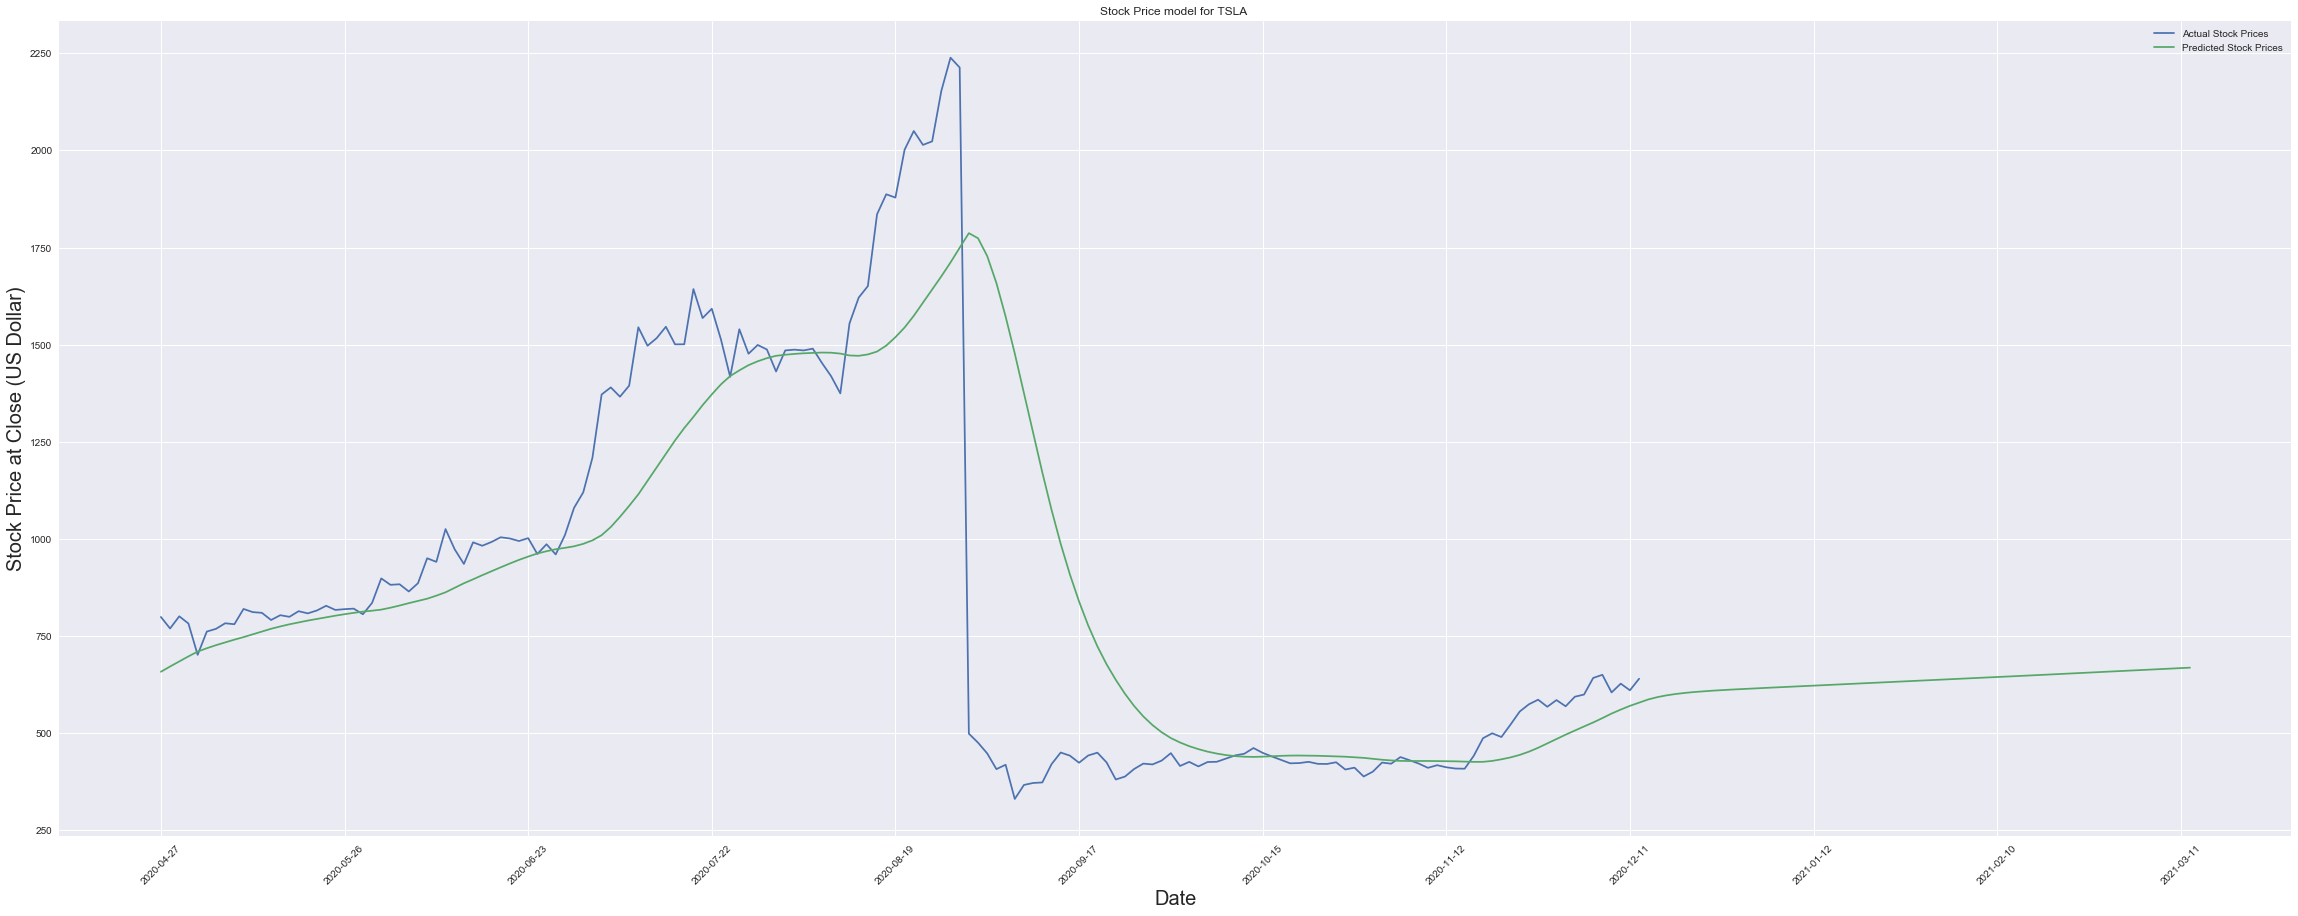

In [11]:
import datetime as dt
import pandas as pd
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
plt.style.use("seaborn")
# Connect to market-calendar (only includes dates that the market is open)
nyse = mcal.get_calendar('NYSE')
# Pull dates starting at earliest date for ticker, and end in the future based on how predictWindow
schedule = nyse.schedule(start_date=df["date"].iloc[trainSize+lookbackWindow], end_date=dt.date.today()+ dt.timedelta(days=predictWindow*2))
schedule["market_close"] = pd.to_datetime(schedule["market_close"]).dt.date
NYSE_Dates = schedule["market_close"].astype(str).to_list()
# Increment dates every 20 to see on X axis
Clean_NYSE_Dates = NYSE_Dates[0::20]
# Combine test predictions with future predictions to compare to actual test data
predictPlot = list(final_test_predictions) + list(final_future_predictions)
# Establish Plot
plt.figure(figsize=(40,15))
plt.title(f'Stock Price model for {ticker} ')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Stock Price at Close (US Dollar)', fontsize=20)
# Increment dates by same factor as 'skips' in Dates list to plot accurate datestamps on X axis
plt.xticks(range(0,dataLength,20),Clean_NYSE_Dates, rotation=45)
# Plot actual values and predictions on same graph
plt.plot(close_data_set[trainSize+lookbackWindow:])
plt.plot(predictPlot)
plt.legend(["Actual Stock Prices", "Predicted Stock Prices"])
plt.show()

In [12]:
Dash_df = pd.DataFrame()
true_close_price = close_data_set[trainSize+lookbackWindow:]
actual_close_price = np.append(true_close_price, np.repeat(np.nan, (len(predictPlot) - len(true_close_price))))
Dash_df["Actual Stock Price ($ USD)"] = actual_close_price
predicted_close_price = np.concatenate(predictPlot).ravel().tolist()
Dash_df["Predicted Close Price ($ USD)"] = predicted_close_price
Dash_df["Predicted Close Price ($ USD)"] = Dash_df["Predicted Close Price ($ USD)"].round(2) 
Dash_df["Date"] = NYSE_Dates[:len(predicted_close_price)]
Dash_df.set_index("Date", inplace=True, drop=True)
Dash_df = Dash_df.assign(stock=np.nan)
Dash_df.iloc[0,2] = ticker
Dash_df

,Actual Stock Price ($ USD),Predicted Close Price ($ USD),stock
Date,,,
2020-04-27,798.75,657.70,TSLA
2020-04-28,769.12,671.23,NaN
2020-04-29,800.51,684.16,NaN
2020-04-30,781.88,697.31,NaN
2020-05-01,701.32,709.57,NaN
...,...,...,...
2021-03-08,NaN,663.61,NaN
2021-03-09,NaN,664.78,NaN
2021-03-10,NaN,665.94,NaN


In [13]:
Dash_df.to_csv("test_data/Stock_Close_Predictions.csv")